In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
#import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [500])
W = tf.placeholder("float", [784, 500])
X = tf.placeholder("float", [None, 784])
_h0= tf.nn.sigmoid(tf.matmul(X, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)
err = tf.reduce_mean(tf.square(X - v1))

In [4]:
cur_w = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [5]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48123777

Epoch: 0 reconstruction error: 0.063080
Epoch: 1 reconstruction error: 0.054159
Epoch: 2 reconstruction error: 0.050470
Epoch: 3 reconstruction error: 0.047826
Epoch: 4 reconstruction error: 0.046418


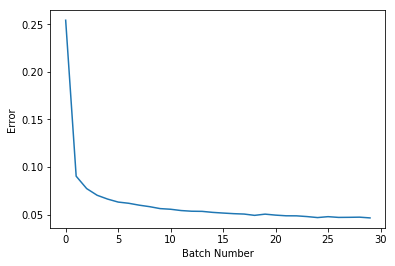

In [6]:
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

In [7]:
uw = weights[-1].T
print(uw) # a weight matrix of shape (500,784)

[[-0.23086776 -0.250154   -0.28645724 ... -0.25486204 -0.2569491
  -0.21170163]
 [-0.22003019 -0.25001603 -0.28514373 ... -0.2500211  -0.25508744
  -0.19507398]
 [-0.281409   -0.2683932  -0.32600376 ... -0.25672284 -0.30564088
  -0.26312196]
 ...
 [-0.22040053 -0.25029224 -0.28504625 ... -0.25005835 -0.25513947
  -0.19523968]
 [-0.22011426 -0.25006554 -0.28510064 ... -0.2500197  -0.25521076
  -0.1951268 ]
 [-0.22000198 -0.25000083 -0.2850024  ... -0.2500013  -0.25500405
  -0.19500187]]


In [8]:
def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    # 对参数进行断言，确保它们都是二维元组
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output np ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        # colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = np.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = np.zeros(out_shape, dtype=dt)

        # begin to tile the images
        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                # a 2-D array in which every row is a flattened image
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array
    
def scale_to_unit_interval(ndar, eps=1e-8):
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

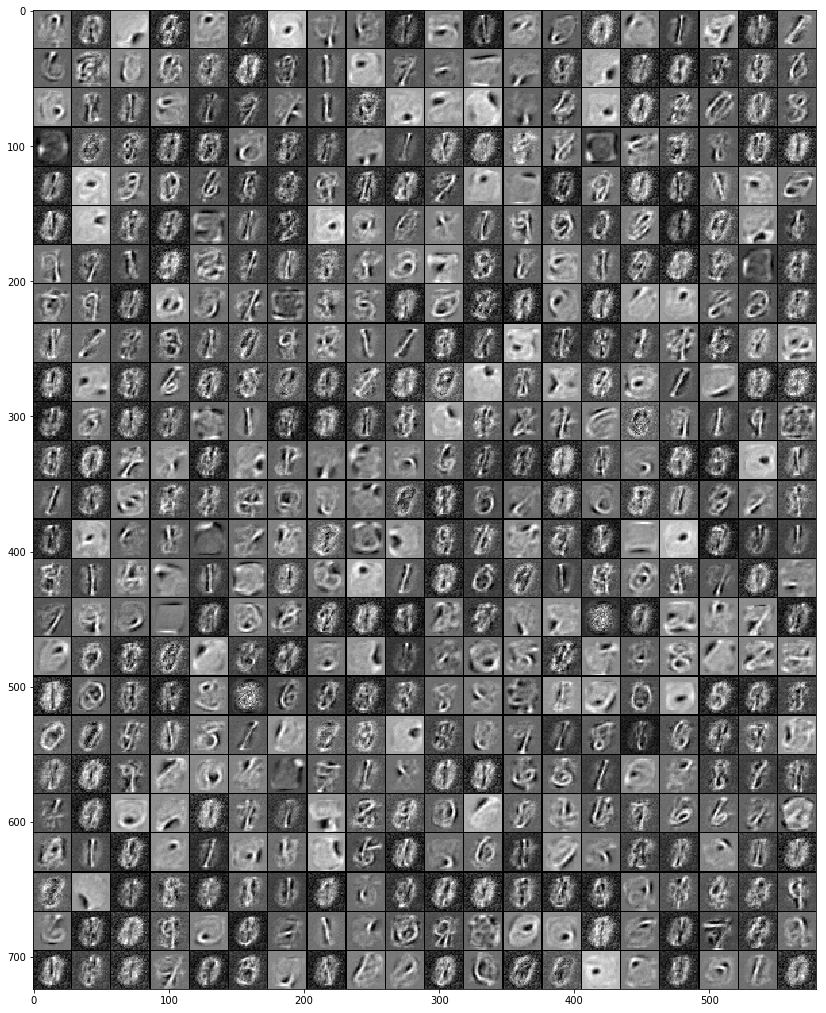

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray') 

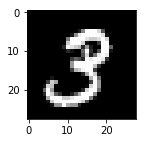

In [10]:
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')  #you can experiment different colormaps (Greys,winter,autumn)

In [11]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

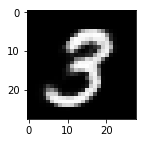

In [12]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 